### Last_FM_Project

#### explicit feedback :
for example, we have the ratings users have given to movies they watched.

#### implicit feedback : 
when a user doesn't rate a movie, it's a user’s conscious choice, and it is a good source of information on what he thinks he might like.

#### Example of using lighFM :
Model training is accomplished via SGD (stochastic gradient descent). This means that for every pass through the data --- an epoch --- the model learns to fit the data more and more closely. We'll run it for 30 epochs in this example. We can also run it on multiple cores, so we'll set that to 2. (The dataset in this example is too small for that to make a difference, but it will matter on bigger datasets.)

In [2]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

# Instantiate and train the model
model = LightFM(loss='warp') # WARP is an implicit feedback model:
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
test_precision = precision_at_k(model, data['test'], k=5).mean()

In [3]:
import numpy as np

def sample_recommendation(model, data, user_ids):
    n_users, n_items = data['train'].shape
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        print("User %s" % user_id)
        print("     Known positives:")
        for x in known_positives[:3]:
            print("        %s" % x)

        print("     Recommended:")
        for x in top_items[:3]:
            print("        %s" % x)
sample_recommendation(model, data, [3, 25, 450])

User 3
     Known positives:
        Contact (1997)
        Air Force One (1997)
        In & Out (1997)
     Recommended:
        L.A. Confidential (1997)
        English Patient, The (1996)
        Conspiracy Theory (1997)
User 25
     Known positives:
        Fargo (1996)
        Godfather, The (1972)
        L.A. Confidential (1997)
     Recommended:
        Godfather, The (1972)
        Titanic (1997)
        L.A. Confidential (1997)
User 450
     Known positives:
        Event Horizon (1997)
        Scream (1996)
        Conspiracy Theory (1997)
     Recommended:
        G.I. Jane (1997)
        Conspiracy Theory (1997)
        Scream (1996)


In [4]:
import pandas as pd
import numpy as np

In [5]:
plays = pd.read_csv('lightFM/data/user_artists.dat', sep='\t')
artists = pd.read_csv('lightFM/data/artists.dat', sep='\t', usecols=['id','name'])

# Merge artist and user pref data
ap = pd.merge(artists, plays, how="inner", left_on="id", right_on="artistID")
ap = ap.rename(columns={"weight": "playCount"})

# Group artist by name
artist_rank = ap.groupby(['name']) \
    .agg({'userID' : 'count', 'playCount' : 'sum'}) \
    .rename(columns={"userID" : 'totalUsers', "playCount" : "totalPlays"}) \
    .sort_values(['totalPlays'], ascending=False)

artist_rank['avgPlays'] = artist_rank['totalPlays'] / artist_rank['totalUsers']
print(artist_rank)

                    totalUsers  totalPlays     avgPlays
name                                                   
Britney Spears             522     2393140  4584.559387
Depeche Mode               282     1301308  4614.567376
Lady Gaga                  611     1291387  2113.563011
Christina Aguilera         407     1058405  2600.503686
Paramore                   399      963449  2414.659148
...                        ...         ...          ...
Morris                       1           1     1.000000
Eddie Kendricks              1           1     1.000000
Excess Pressure              1           1     1.000000
My Mine                      1           1     1.000000
A.M. Architect               1           1     1.000000

[17632 rows x 3 columns]


In [6]:
ap.head()

,id,name,userID,artistID,playCount
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [7]:
# Merge into ap matrix
#ap = ap.join(artist_rank, on="name", how="inner") \
    #.sort_values(['playCount'], ascending=False)

# Preprocessing
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
ap = ap.assign(playCountScaled=play_count_scaled)
#print(ap)

# Build a user-artist rating matrix 
ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
ratings = ratings_df.fillna(0).values

# Show sparsity
sparsity = float(len(ratings.nonzero()[0])) / (ratings.shape[0] * ratings.shape[1]) * 100
print("sparsity: %.2f" % sparsity)
#print(ap.il)

sparsity: 0.28


In [8]:
from scipy.sparse import csr_matrix

# Build a sparse matrix
X = csr_matrix(ratings)

n_users, n_items = ratings_df.shape
print("rating matrix shape", ratings_df.shape)

user_ids = ratings_df.index.values
artist_names = ap.sort_values("artistID")["name"].unique()
artist_names

rating matrix shape (1892, 17632)


array(['MALICE MIZER', 'Diary of Dreams', 'Carpathian Forest', ...,
       'Coptic Rain', 'Oz Alchemist', 'Grzegorz Tomczak'], dtype=object)

In [9]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset

# Build data references + train test
Xcoo = X.tocoo() #coordonnees xsparse de ratings
data = Dataset() #lighhtFM dataset
data.fit(np.arange(n_users), np.arange(n_items))
interactions, weights = data.build_interactions(zip(Xcoo.row, Xcoo.col, Xcoo.data)) 
train, test = random_train_test_split(interactions)

# Ignore that (weight seems to be ignored...)
#train = train_.tocsr()
#test = test_.tocsr()
#train[train==1] = X[train==1]
#test[test==1] = X[test==1]

# To be completed...


#### SGD model with a learning_rate of 0.05

In [10]:
# Train
model = LightFM(learning_rate=0.05, loss='warp') # model SGD with a learning_rate
model.fit(train, epochs=10, num_threads=2)

In [11]:
# Evaluate
# Measure the precision at k metric for a model: 
# the fraction of known positives in the first k positions of the ranked list of results. A perfect score is 1.0.
train_precision = precision_at_k(model, train, k=3).mean()
test_precision = precision_at_k(model, test, k=3, train_interactions=train).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.45, test 0.21.
AUC: train 0.97, test 0.86.


In [12]:
# Predict
scores = model.predict(0, np.arange(n_items))
top_items = artist_names[np.argsort(-scores)]
print(top_items[0:10])

['The Beatles' 'Radiohead' 'David Bowie' 'Depeche Mode' 'Muse' 'Coldplay'
 'The Killers' 'Arctic Monkeys' 'Kings of Leon' 'Sigur Rós']


#### Other models :

Four loss functions are available:
- logistic: useful when both positive (1) and negative (-1) interactions
  are present.
- BPR: Bayesian Personalised Ranking [1]_ pairwise loss. Maximises the
  prediction difference between a positive example and a randomly
  chosen negative example. Useful when only positive interactions
  are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise [2]_ loss. Maximises
  the rank of positive examples by repeatedly sampling negative
  examples until rank violating one is found. Useful when only
  positive interactions are present and optimising the top of
  the recommendation list (precision@k) is desired.
- k-OS WARP: k-th order statistic loss [3]_. A modification of WARP that
  uses the k-th positive example for any given user as a basis for pairwise
  updates.: Bayesian Personalised Ranking [1]_ pairwise loss. Maximises the
  prediction difference between a positive example and a randomly
  chosen negative example. Useful when only positive interactions
  are present and optimising ROC AUC is desired.
  
WARP: Weighted Approximate-Rank Pairwise [2]_ loss. Maximises
  the rank of positive examples by repeatedly sampling negative
  examples until rank violating one is found. Useful when only
  positive interactions are present and optimising the top of
  the recommendation list (precision@k) is desired.
k-OS WARP: k-th order statistic loss [3]_. A modification of WARP that
  uses the k-th positive example for any given user as a basis for pairwise
  updates.

#### Precision and AUC measurements for the 4 different models of lightFM

In [13]:
model = ['warp','bpr','warp-kos','logistic']
train_precision = []
test_precision = []
train_auc = []
test_auc = []

for mod in model:
    model = LightFM(loss=mod) # model SGD with a learning_rate
    model.fit(train, epochs=10, num_threads=2)
    
    train_precision.append(precision_at_k(model, train, k=3).mean())
    test_precision.append(precision_at_k(model, test, k=3, train_interactions=train).mean())

    train_auc.append(auc_score(model, train).mean())
    test_auc.append(auc_score(model, test, train_interactions=train).mean())

In [14]:
res = pd.DataFrame([train_precision,test_precision,train_auc,test_auc], index = ['train_precision','test_precision'
                                        ,'train_auc','test_auc'] ,columns =['warp','bpr','warp-kos','logistic'])
res   

,warp,bpr,warp-kos,logistic
train_precision,0.448270,0.459922,0.380473,0.233051
test_precision,0.205882,0.199109,0.169875,0.089305
train_auc,0.962830,0.844371,0.888872,0.887278
test_auc,0.856163,0.776621,0.820650,0.809755


#### item_embeddings	 :
    item_embeddings (np.float32 array of shape [n_item_features, n_components]) – Contains the estimated latent vectors for item features. The [i, j]-th entry gives the value of the j-th component for the i-th item feature. In the simplest case where the item feature matrix is an identity matrix, the i-th row will represent the i-th item latent vector.

#### user_embeddings :
user_embeddings (np.float32 array of shape [n_user_features, n_components]) – Contains the estimated latent vectors for user features. The [i, j]-th entry gives the value of the j-th component for the i-th user feature. In the simplest case where the user feature matrix is an identity matrix, the i-th row will represent the i-th user latent vector.

#### PCA and TruncateSVD :

In [ ]:
# Preprocessing
#pc = ap.playCount
#play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
#ap = ap.assign(playCountScaled=play_count_scaled)
#print(ap)

# Build a user-artist rating matrix 
#ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
#ratings = ratings_df.fillna(0).values

#### Ground truth :

In [15]:
#Artistes dont le userID est de donné en parametre classés suivant playCountScaled:
def get_ground_truth_artists_for_user(userID):    
    art = list(enumerate(ratings[userID]))
    art = sorted(art, key=lambda x: x[1], reverse=True)
    art = art[1:31]
    art_indx = [i[0] for i in art]  
    artistes = []
    for i in art_indx:
        artistes.append(ap['name'][ap['artistID']==i].unique()[0])
    return artistes

In [16]:
from sklearn.decomposition import TruncatedSVD

# Build a sparse matrix
X = csr_matrix(ratings)

svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
X_matrix_svd = svd.fit_transform(X)

In [17]:
from copy import deepcopy
# Function that takes in user_id as input and outputs most similar users and the artits ratings
def get_recommendations(user_id, cosine_sim):
    
    start = time.time()
    
    # Get the index of the user that matches the title
    #idx = indices[user]

    # Get the pairwsie similarity scores of all users with that user
    sim_scores = list(enumerate(cosine_sim))

    # Sort the users based on the similarity ratings of the artists
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 50 most similar users
    sim_scores = sim_scores[1:11]

    # Get the user indices similar to the user in parameter
    user_indices = [i[0] for i in sim_scores]    
    
    time_res = time.time() - start
    
    artist_top = []
    idx_i_list={}
    ratings_ = deepcopy(ratings)
    for i in user_indices:
        # take the 5 most important artists for this user
        for j in range(5):
            idx_i = np.argmax(ratings_[i])
            idx_i_list[i]=idx_i  
            ratings_[i][idx_i]=-1
        for i, idx in idx_i_list.items():
            if ap['name'][ap['artistID']==idx].unique()[0] not in artist_top:
                artist_top.append(ap['name'][ap['artistID']==idx].unique()[0]) 
            
    # Return the top 50 most similar users ratings of artists
    return artist_top,time_res, idx_i_list

In [18]:
import time
from sklearn.metrics.pairwise import linear_kernel


def cosine_similarity(user_id):
    cos_sim = linear_kernel(X_matrix_svd,X_matrix_svd[user_id].reshape(1, -1))
    return cos_sim

In [19]:
user_id = 0
artist_top, time_res, idx_i_list = get_recommendations(user_id, cosine_sim = cosine_similarity(user_id))

print(time_res)

0.015358448028564453


In [20]:
def most_rec_artists():
    artist_names_rec_hist = []
    for i in range(10):
        userID = np.random(ratings)
        artist_names_rec_hist.append(get_top_artists_recommended_svd(userID))
        
    return artist_names_rec_hist

#### Accuracy score :
for the SVD model

In [24]:
artist_truth = get_ground_truth_artists_for_user(0)

In [25]:
def accuracy_score(artists_recommended):
    score = 0
    for art in artists_recommended:
        if art in artist_truth:
            score+=1
    return score/len(artists_recommended)

In [26]:
acc_score = accuracy_score(artist_top)
round(acc_score,3)

0.1

In [27]:
acc_score = accuracy_score(top_items[0:18])
round(acc_score,3)

0.111

##### As for the accuracy the results are quite the same for the LightFM and the SVD model

#### AUC score :    

In [28]:
from sklearn.metrics import roc_auc_score

y = artist_truth

#roc_auc_score(y, artist_top, multi_class='ovr')

In [29]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
#X_train, X_test, y_train, y_test = train_test_split(ap, ap['artistID'], test_size=0.2) # 70% training and 30% test


In [51]:
from sklearn.metrics import classification_report

#print(classification_report(y_test, top_items))

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

#average_precision = average_precision_score(y_test, y_pred)

#disp = plot_precision_recall_curve(clf, scaled_data_test, y_test)
#disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#### fit_partial :

#### Convergence du modle LightFM :

In [31]:
model = LightFM(learning_rate=0.05, loss='warp') 
auc_test = []
def fit_partial():
    for i in range(1,50):
        model.fit_partial(train, epochs=1, num_threads=2)
        auc_test.append(auc_score(model, test).mean())
    return auc_test
auc_test = fit_partial()

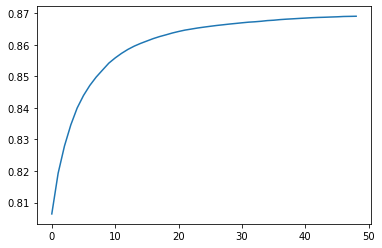

In [32]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(auc_test))
plt.plot(x, np.array(auc_test))

plt.show() # affiche la figure a l'ecran

#### Grid search cv :

In [30]:
from sklearn.metrics import fbeta_score, make_scorer

scorer = make_scorer(auc_score(model, test))

In [33]:
# Train
model = LightFM(learning_rate=0.05, loss='warp') # model SGD with a learning_rate
model.fit(train, epochs=10, num_threads=2)

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import fbeta_score, make_scorer

import warnings

params = {
    'no_components': [5, 10, 20, 40, 80],
    'k' : [3, 5, 10, 15, 20],
    'n' : [5, 10, 20, 40, 80],
    'learning_schedule': ['adagrad', 'adadelta'],
    'learning_rate' : [0.5, 0.1, 0.05, 0.01, 0.005]
}
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#scorer = make_scorer(auc_score)
scorer = make_scorer(auc_score(model, test))

grid = GridSearchCV(estimator=LightFM(),
                    param_grid=params, scoring=scorer, verbose=1)
#grid.fit(train, epochs=10, num_threads=2)

#### Test avec plusieurs parametres : 
    params = {
    'no_components': [5, 10, 20, 40, 80],
    'k' : [3, 5, 10, 15, 20],
    'n' : [5, 10, 20, 40, 80],
    'learning_schedule': ['adagrad', 'adadelta'],
    'learning_rate' : [0.5, 0.1, 0.05, 0.01, 0.005]
}

In [47]:
params = {
    'no_components': [5, 10, 20, 40, 80],
    'k' : [3, 5, 10, 15, 20],
    'n' : [5, 10, 20, 40, 80],
    'learning_schedule': ['adagrad', 'adadelta'],
    'learning_rate' : [0.5, 0.1, 0.05, 0.01, 0.005]
}
train_precision = []
test_precision = []
train_auc = []
test_auc = []
learning_schedule = ['adagrad', 'adadelta']
for ls in learning_schedule :
    for i in range(5):    
        model = LightFM(no_components = params['no_components'][i],
                        k = params['k'][i],
                        n = params['n'][i],
                        learning_schedule = ls,
                        learning_rate = params['learning_rate'][i],
                        loss='warp')
        model.fit(train, epochs=10, num_threads=2)
    
        train_precision.append(precision_at_k(model, train, k=3).mean())
        test_precision.append(precision_at_k(model, test, k=3, train_interactions=train).mean())

        train_auc.append(auc_score(model, train).mean())
        test_auc.append(auc_score(model, test, train_interactions=train).mean())           
     

In [48]:
res = pd.DataFrame([train_precision,test_precision,train_auc,test_auc], index = ['train_precision','test_precision'
                                        ,'train_auc','test_auc'] ,columns =['algo1','algo2','algo3','algo4','algo5','algo6','algo7','algo8','algo9','algo10'])
res   

,algo1,algo2,algo3,algo4,algo5,algo6,algo7,algo8,algo9,algo10
train_precision,0.001062,0.429052,0.514685,0.355449,0.333687,0.374912,0.418436,0.458422,0.514862,0.593418
test_precision,0.000177,0.185284,0.226418,0.159220,0.154787,0.177128,0.189362,0.208156,0.211170,0.220390
train_auc,0.536034,0.983482,0.982749,0.898725,0.888921,0.930433,0.950565,0.970104,0.983736,0.992808
test_auc,0.498819,0.844516,0.869450,0.825406,0.821572,0.850311,0.862213,0.878276,0.886117,0.887611


#### L'algo le plus performant en terme de resultat pour l'auc_test :

In [25]:
res.max(axis = 1)

train_precision    0.319710
test_precision     0.155142
train_auc          0.903952
test_auc           0.817408
dtype: float64

In [45]:
train_precision = []
test_precision = []
train_auc = []
test_auc = []
model = LightFM(no_components = 80,
                        k = 20,
                        n = 80,
                        learning_schedule = 'adadelta',
                        learning_rate = 0.005,
                        loss='warp')
model.fit(train, epochs=10, num_threads=2)
    
train_precision.append(precision_at_k(model, train, k=3).mean())
test_precision.append(precision_at_k(model, test, k=3, train_interactions=train).mean())

train_auc.append(auc_score(model, train).mean())
test_auc.append(auc_score(model, test, train_interactions=train).mean())     

In [46]:
res = pd.DataFrame([train_precision,test_precision,train_auc,test_auc], index = ['train_precision','test_precision'
                                        ,'train_auc','test_auc'] ,columns =['algo10'])
res 

,algo10
train_precision,0.599434
test_precision,0.206206
train_auc,0.992281
test_auc,0.887306
